# PageRank Project #7

In this project i will implement the PageRank algorithm, originally developed by Google in 1998 to rank websites. After the implementation details I will provide some experiments where, given a dataset of websites and links between them, I will consider the underlying network/graph and compute the rank of every page. Since the PageRank algorithm takes into account the possibility for the user of jumping between unlinked pages. I will perform some experiments where I vary the parameter $\alpha$ which regulates the probability of randomly jumping in the graph, and analyze the results.

## Load and Prepare the Data

Let's import the dataset and perform some modifications to make it more readable.
In a txt file we have the list of 9664 websites and of 16150 links connecting them. I will store these data in two separate pandas dataframe. 

In the code I will use equivalently:

website <--> node

link    <--> edge  

In [1]:
import numpy as np
import pandas as pd

# Data Source:
# http://www.cs.cornell.edu/courses/cs685/2002fa/data/gr0.California


nodes = pd.read_csv('GraphDB.txt',
                     sep = ' ',
                     nrows = 9664)

In [2]:
nodes.head()

,Number,Node,WebSite,Unnamed: 3
0,n,0,http://www.berkeley.edu/,NaN
1,n,1,http://www.caltech.edu/,NaN
2,n,2,http://www.realestatenet.com/,NaN
3,n,3,http://www.ucsb.edu/,NaN
4,n,4,http://www.washingtonpost.com/wp-srv/national/...,NaN


In [3]:
#drop useless columns
nodes = nodes.drop(columns=["Number","Unnamed: 3"])

In [4]:
nodes.head()

,Node,WebSite
0,0,http://www.berkeley.edu/
1,1,http://www.caltech.edu/
2,2,http://www.realestatenet.com/
3,3,http://www.ucsb.edu/
4,4,http://www.washingtonpost.com/wp-srv/national/...


Let's now read the links

In [5]:
# read all the edges that involve 
edges = pd.read_csv('GraphDB.txt',
                     sep = ' ',
                     skiprows = 9665)

In [6]:
edges.head()

,Number,InEdge,OutEdge
0,e,0,449
1,e,0,450
2,e,0,451
3,e,0,452
4,e,0,453


In [7]:
edges.shape

(16150, 3)

In [8]:
edges = edges.drop(columns=['Number'])

In [9]:
nodes['Node'] = pd.to_numeric(nodes['Node'])
edges['InEdge'] = pd.to_numeric(edges['InEdge'])
edges['OutEdge'] = pd.to_numeric(edges['OutEdge'])

## Graph Class

A simple implementation of graph object

In [10]:
class graph:
    
    def __init__(self, gdict=None):
        '''
        Input:
        
        gdict: dictionary where keys are the nodes in the graph
        and the values are the lists of reachable nodes
        '''
        
        if gdict is None:
            gdict = {}
        
        self.gdict = gdict
    
    #Retrieve the nodes of the graph
    def GetNodes(self) -> list: 
        return list(self.gdict.keys())

    #Retrieve outcoming egdes
    def GetReachableNodes(self, node: int) -> list: 
        '''
        Input:
        
        node: an int representing the starting node
        '''
        try:
            out = list(self.gdict[node])
            return out 
        except:
            print(f"Error: node {node} is not in the graph!")
    

Now we can construct a dictionary where the keys are the nodes in the graph and the values are the lists with the outgoing edges relative to the key node

In [11]:
# construct a dict for our graph 

gdict = {int(v) : [int(e) for e in edges.OutEdge[edges.InEdge == v]] for v in nodes.Node}

Save the data

In [16]:
# import csv

# # save the dict
# with open('dict.csv', 'w') as csv_file:  
#     writer = csv.writer(csv_file)
#     for key, value in gdict.items():
#         writer.writerow([key, value])
    


# to read it back

# with open('dict.csv') as csv_file:
#     reader = csv.reader(csv_file)
#     mydict = dict(reader)


In [17]:
# instanciate a graph object for our graph
g = graph(gdict)

### PageRank Algorithm

The algorithm models the behavior of the generic user as a random path in the graph where, once the user lands on a node, it will either move to a linked page with probability (1 - $\alpha$) or randomly jump towards any node in the graph with probability $\alpha$.

Formally we get a Markov Chain whose transition matrix is: $$ P = \alpha 1^T J + (1-\alpha) R$$ where J is a constant vector for the random jumps while R stores the information about the topology of the graph.

The algorithm aims at computing the weight vector $\pi$, which, given the topology of the graph, assignes to each website a score, so that we can retrieve the most important websites and rank them.

The weight vector $\pi$ is the stationary distribution of the associated Markov Chain and, formally, the unique stochastic eigenvector associated to the aigenvalue 1, solution of: $$x P = x.$$

### Solving the Linear System

Since P has usually millions of rows we can not directly solve the system, instead we use an iterative method.

Let $\pi_0$ be an initial guest for the score vector and let $\epsilon$ be a fixed tolerance. Do
$$\pi_{t+1} = \pi_{t} P$$
While
$$ | \pi_{t+1} - \pi_{t} | \geq \epsilon \quad \quad \quad t = 0,1,2,...$$

### Topic specific PageRank

We can force the user to jump only in a finite subset of webpages, ideally related to a specific topic, by modifying the jump vector.
If S is the subset of topic specific pages: 
$$ (J_S)_{i} = 
\begin{cases}
  \frac{1}{|S|} & i \in S \\
       0 & \text{otherwise} 
\end{cases}
$$
And now solve the system with: $$P_S = \alpha 1^T J_S + (1-\alpha) R$$

In [18]:
def PageRank(R, alpha = .2, J = None, S: list = None, x_0 = None, eps = 10**(-2)):
    '''
    Implementation of the PageRank algorithm using an iterative
    method.
    
    Inputs:
    
    R:       stochastic transition matrix
    alpha:   damping factor
    J:       jump vector
    S:       list of pages specific to a certain topic
    x_0:     initial guest
    eps:     precision
    
    Outputs:
    
    pi:      PageRank vector
    error:   approximation error at every iteration
    it:      number of iterations to reach convergence
    '''
    
    # number of nodes
    tmp = R.shape[0]
    
    # initialize x_0
    if x_0 is None:
        x_0 = np.random.rand(1,tmp)
    
    # initialize J/J_{S}
    if S is not None:
        # the number of pages specific to a certain topic
        # can not be greater than the overall number of
        # pages in the dataset  
        assert len(S) <= R.shape[0] 
        
        # if S is given than J must be None since it would be
        # automatically deduced from S
        assert J is None
        J = np.array([1/len(S) if i in S else 0 for i in range(tmp)])
        
    else:
        if J is None:
            # basic version of J with equal probabilities
            J = np.ones(shape=(1,tmp)) * (1/tmp)
    
    J = np.reshape(J, (1,tmp))
    
    # initialize x_{t+1}
    pi = x_0 + 1
    
    # initialize 1^T
    one_vector = np.ones(shape=(tmp,1))
    
    # initialize the error vector
    error = [np.linalg.norm( pi - x_0 )]
    
    # iterative matrix
    P = alpha * np.matmul(one_vector, J) + (1 - alpha) * R
    
    # initialize the number of itetations
    it = 1
    
    while np.linalg.norm( pi - x_0 ) >= eps:
        # do computations
        _ = np.matmul(x_0, P)
        
        # update
        x_0 = pi
        pi = _
        
        error.append(np.linalg.norm( pi - x_0))
        it += 1
        
    return pi.flatten(), error, it
        
        

### Construct R

In [19]:
num_nodes = len(g.GetNodes())

R = np.zeros(shape = (num_nodes,num_nodes))

for i in range(num_nodes):
    # whenever there is a link fron node i to node j
    # we set R[i][j] = 1/len(g.gdict[i]).
    # However this quantity depends only on i, so that we
    # can avoid to compute it for every j. Such quantity may not
    # exist for nodes without outcoming edges, but in such case
    # R[i][j] = 0 for every j and so (because of how we initialized R)
    # we don't need to perform any update
    try:
        r_i_j = 1/len(g.gdict[i])
    except:
        continue
        
    for j in range(num_nodes):
        if j in g.gdict[i]:
            R[i,j] = r_i_j

In [20]:
R.shape

(9664, 9664)

### Let's try the algorithm on our data

In [21]:
%%time
pi, error, it = PageRank(R)

CPU times: total: 22.4 s
Wall time: 7.03 s


Plot the error at every iteration

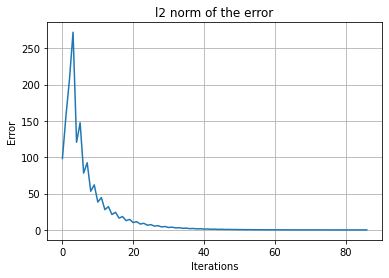

In [22]:
import matplotlib.pyplot as plt


plt.plot(error)
plt.xlabel("Iterations")
plt.ylabel("Error")
plt.title("l2 norm of the error")
plt.grid(True)
plt.show()

How many iteration did the algorithm need to converge?

In [23]:
it

87

## What are the top 10 websites?

In [24]:
TopWebSites = [x for _, x in sorted(zip(pi, list(nodes.WebSite)), key=lambda pair: pair[0], reverse=True)]
TopWebSites[:10]

['http://www.ucdavis.edu/',
 'http://search.ucdavis.edu/',
 'http://www.uci.edu/',
 'http://www.lib.uci.edu/',
 'http://www.calacademy.org/',
 'http://spectacle.berkeley.edu/',
 'http://vision.berkeley.edu/VSP/index.shtml',
 'http://www.gene.com/ae/bioforum/',
 'http://www.ucr.edu/',
 'http://www.students.ucr.edu/']

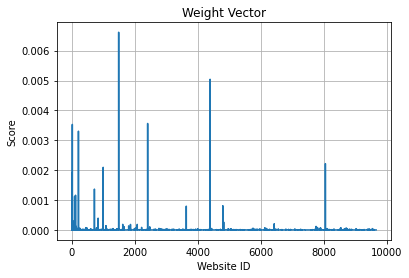

In [25]:
plt.plot(pi)
plt.title("Weight Vector")
plt.grid(True)
plt.xlabel("Website ID")
plt.ylabel("Score")
plt.show(True)

### Topic Specific PageRank Experiments

Assume we restrict to the first 10 websites

In [26]:
pi_TS_1, *_ = PageRank(R, S=list(range(10)))

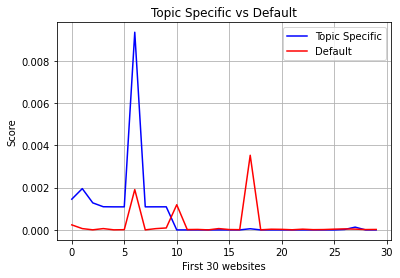

In [27]:
plt.plot(pi_TS_1[:30], color="blue", label="Topic Specific")
plt.plot(pi[:30], color="red", label="Default")
plt.legend()
plt.grid(True)
plt.xlabel("First 30 websites")
plt.ylabel("Score")
plt.title("Topic Specific vs Default")
plt.show()

We can immidiately see that in the case of TSPR the first 10 websites are now more important. Excluded websites that were previously important, like the number 17, is a clear example of node that has still a positive score but lowered.

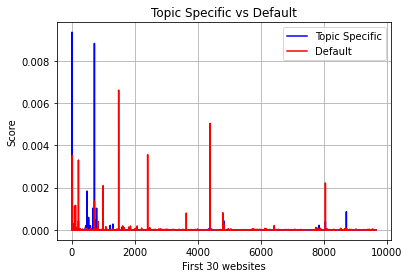

In [28]:
plt.plot(pi_TS_1, color="blue", label="Topic Specific")
plt.plot(pi, color="red", label="Default")
plt.legend()
plt.grid(True)
plt.xlabel("First 30 websites")
plt.ylabel("Score")
plt.title("Topic Specific vs Default")
plt.show()

Let's restrict to the websites from 10 to 20

In [29]:
pi_TS_2, *_ = PageRank(R, S=list(range(10,20)))

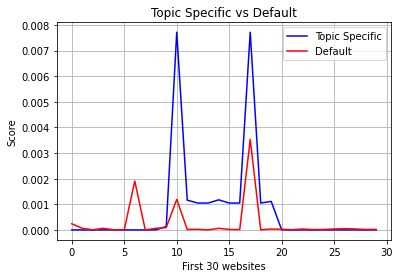

In [30]:
plt.plot(pi_TS_2[:30], color="blue", label="Topic Specific")
plt.plot(pi[:30], color="red", label="Default")
plt.legend()
plt.grid(True)
plt.xlabel("First 30 websites")
plt.ylabel("Score")
plt.title("Topic Specific vs Default")
plt.show()

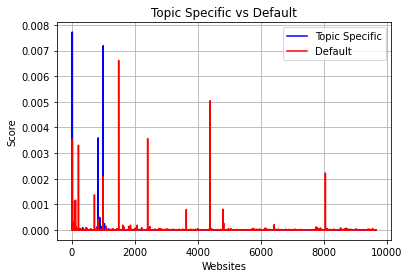

In [31]:
plt.plot(pi_TS_2, color="blue", label="Topic Specific")
plt.plot(pi, color="red", label="Default")
plt.legend()
plt.grid(True)
plt.xlabel("Websites")
plt.ylabel("Score")
plt.title("Topic Specific vs Default")
plt.show()

Let's now consider a random sample of size 100

In [32]:
from random import sample
pi_TS_3, *_ = PageRank(R, S=list(sample(range(9664),100)))

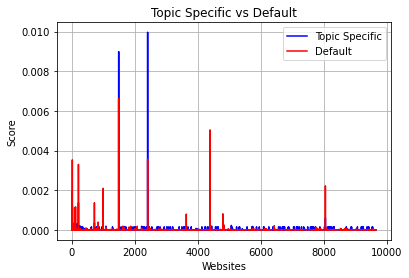

In [33]:
plt.plot(pi_TS_3, color="blue", label="Topic Specific")
plt.plot(pi, color="red", label="Default")
plt.legend()
plt.grid(True)
plt.xlabel("Websites")
plt.ylabel("Score")
plt.title("Topic Specific vs Default")
plt.show()

Since the Topic Specific websites were selected at random the final effect is basically that we averaged the scores all over the nodes, with only a few very important websites

### Experiments for various values of $\alpha$

In [34]:
pi = []
it = []
alpha = [.01,.1,.3,.5,.7,.9,.99]

for a in alpha:
    pi_, _, it_ = PageRank(R, alpha = a)
    pi.append(pi_)
    it.append(it_)

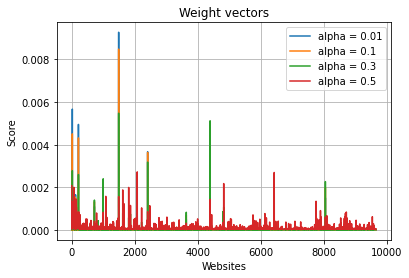

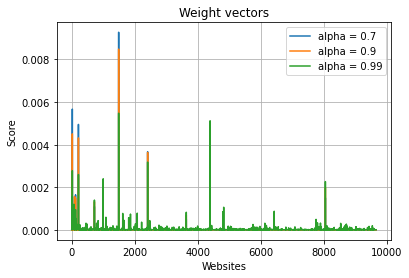

In [35]:
for i, a in enumerate(alpha[:4]):
    plt.plot(pi[i], label=f"alpha = {str(a)}")
plt.title("Weight vectors")
plt.xlabel("Websites")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.show()

for i, a in enumerate(alpha[4:]):
    plt.plot(pi[i], label=f"alpha = {str(a)}")
plt.title("Weight vectors")
plt.xlabel("Websites")
plt.ylabel("Score")
plt.legend()
plt.grid(True)

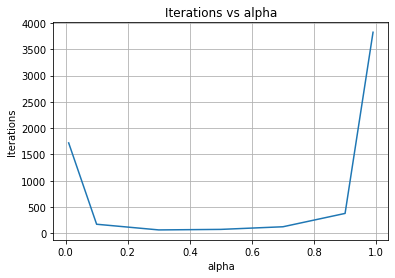

In [36]:
plt.plot(alpha,it)
plt.title("Iterations vs alpha")
plt.xlabel("alpha")
plt.ylabel("Iterations")
plt.grid(True)
plt.show()

I can conclude that the greater the value of $\alpha$ the more uniform the distribution of the weights is. A greater $\alpha$ means greater probability of randomly jumping from one node to another and so all the nodes tend to achieve similar importance; moreover it looks like extreme values of $\alpha$ imply more iterations to reach convergence.